Inspired by Chau Ngoc Huynh's kernel

In [1]:
import pandas as pd
import numpy as np

In [39]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
import datetime
import gc
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_hist_trans = pd.read_csv('historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('new_merchant_transactions.csv')

In [5]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


## Data Preprocessing

In [7]:
# Fill NAs
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [8]:
# Convert dates
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

## Aggregate new features to data

In [9]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [10]:
# Aggregate history transactions
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year',\
            'subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])\
                                    ['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max']\
                                            - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']\
                                                    / df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today()\
                                            - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

39

In [11]:
# Aggregate new transactions
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year',\
            'subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])\
                                            ['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] =\
        (df_hist_trans_group['new_hist_purchase_date_max']\
       - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] =\
        df_hist_trans_group['new_hist_purchase_date_diff']\
       /df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] =\
        (datetime.datetime.today()\
       - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

21

## Visualize target data 

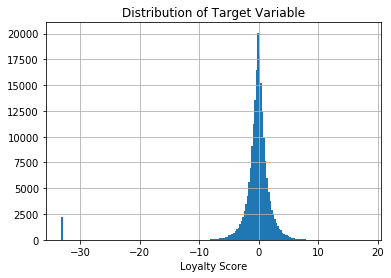

In [12]:
# Plot the distribution of target variable
plt.hist(df_train['target'],200)
plt.title('Distribution of Target Variable')
plt.xlabel('Loyalty Score')
plt.grid()

In [13]:
# Count outliers
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [14]:
# Create hist-new interactions
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Data columns (total 87 columns):
first_active_month                       201917 non-null datetime64[ns]
card_id                                  201917 non-null object
feature_1                                201917 non-null float64
feature_2                                201917 non-null float64
feature_3                                201917 non-null float64
target                                   201917 non-null float64
hist_month_nunique                       201917 non-null int64
hist_hour_nunique                        201917 non-null int64
hist_weekofyear_nunique                  201917 non-null int64
hist_dayofweek_nunique                   201917 non-null int64
hist_year_nunique                        201917 non-null int64
hist_subsector_id_nunique                201917 non-null int64
hist_merchant_id_nunique                 201917 non-null int64
hist_merchant_category_id_nunique        201917 non-

## Fit models

In [16]:
X = df_train.drop(['card_id', 'first_active_month','target','outliers'],axis=1)
y = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=1)

## Extreme Gradient Boosting

In [17]:
xgb_model = XGBRegressor(n_estimators = 10,learning_rate = 0.5,\
                         max_depth=5,objective='reg:squarederror',metric='rmse')
xgb_model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=5, metric='rmse', min_child_weight=1, missing=None,
             n_estimators=10, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [18]:
y_pred = xgb_model.predict(X)

In [19]:
# Root mean squared error on training set
np.sqrt(mean_squared_error(y, y_pred))

3.599344410082735

In [20]:
# Get the importance of features
Importance = pd.DataFrame({'Importance':xgb_model.feature_importances_*100},
                         index = X.columns)
Importance = Importance.sort_values(by = 'Importance',axis = 0,ascending = False)
Importance

,Importance
hist_category_1_sum,8.360076
hist_weekofyear_nunique,8.276801
hist_month_diff_mean,5.670074
hist_weekend_sum,5.374191
new_hist_month_lag_mean,4.018973
...,...
new_hist_subsector_id_nunique,0.000000
new_hist_weekend_mean,0.000000
new_hist_weekend_sum,0.000000
new_hist_merchant_id_nunique,0.000000


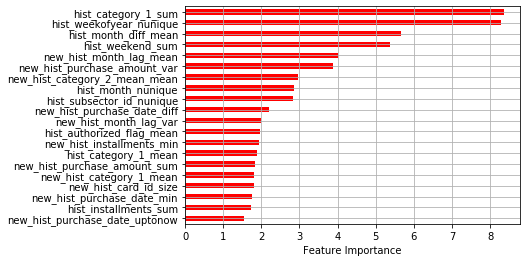

In [57]:
Importance[:20].sort_values(by = 'Importance',axis = 0,ascending = True).\
                            plot(kind = 'barh',color='r')
plt.xlabel('Feature Importance')
plt.gca().legend_ = None
plt.grid()

In [22]:
# get features with non-zero importance
feature_list = Importance[Importance.values!=0].index.values

In [26]:
# Tune parameters for xgboost
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
param_grid = [{'learning_rate':[0.01,0.1,0.5,0.8], 'max_depth':[3,5,10],\
              'n_estimators':[10,50,100,500]}]
grid = GridSearchCV(XGBRegressor(objective='reg:squarederror'),n_jobs=-1,param_grid=param_grid,\
                    scoring='neg_mean_squared_error',cv=kfold,verbose=1)
grid.fit(X[feature_list], y)
print(grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 316.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 431.9min finished


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [37]:
# Root mean squared error for training set
xgb_model = XGBRegressor(n_estimators = 100,learning_rate = 0.1,\
                         max_depth=5,objective='reg:squarederror',metric='rmse')
xgb_model.fit(X[feature_list], y)
y_pred = xgb_model.predict(X[feature_list])
xgb_train_root_mse = np.sqrt(mean_squared_error(y, y_pred))
xgb_train_root_mse

3.5322381136557928

In [41]:
# Cross validation
xgb_cv = np.mean(cross_val_score(xgb_model, X[feature_list], y, cv=3))
xgb_cv

0.09099627695832879

In [36]:
# Root mean squraed error for testing set
xgb_model.fit(X_train[feature_list], y_train)
y_pred = xgb_model.predict(X_test[feature_list])
xgb_test_root_mse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_test_root_mse

3.721535369239202